In [239]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [240]:
def preprocessing(words):
    unwanted_chars = ['ß', 'à', 'ä', 'ç', 'è', 'é', 'ï', 'ñ', 'ó', 'ö', 'ü', 'ā']

    def contains_unwanted_chars(word):
        return any(char in unwanted_chars for char in word)

    words = [haiku for haiku in words if not any(contains_unwanted_chars(word) for word in haiku)]
    return words

def load_data(path):
    with open(path, 'r') as f:
        words = f.read().splitlines()
    words = preprocessing(words)
    return words

words = load_data('../lines.txt')
words = [wr.replace("/", "").replace("$", "") for wr in words]
chars = sorted(list(set(''.join(words)))) #+ ["<S>", "<M>", "<E>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}

In [253]:
def build_dataset(words):
    # make block size max length of a word
    block_size = 8
    X, Y = [], []
    for w in words:
        context = [3] * block_size
        #print(w)
        # w = w.split("  ")
        # chs = ["<S>"] + list(w[0]) + ["<M>"] + list(w[1])+ ["<M>"] + list(w[2]) + ["<E>"]
        for ch in w + ".": #chs:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(f"'{''.join(itos[i] for i in context)}'", '---->', itos[ix])

            context = context[1:] + [ix]
    
    X, Y = torch.tensor(X), torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


import random
random.seed(43)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])

torch.Size([637487, 8]) torch.Size([637487])
torch.Size([79514, 8]) torch.Size([79514])
torch.Size([79753, 8]) torch.Size([79753])


In [254]:
for x,y in zip(Xtrain[:20], Ytrain[:20]):
    print("".join(itos[ix.item()] for ix in x), '--->', itos[y.item()])

........ ---> d
.......d ---> e
......de ---> l
.....del ---> i
....deli ---> c
...delic ---> a
..delica ---> t
.delicat ---> e
delicate --->  
elicate  ---> s
licate s ---> a
icate sa ---> v
cate sav ---> a
ate sava ---> g
te savag ---> e
e savage --->  
 savage  --->  
savage   ---> y
avage  y ---> o
vage  yo ---> u


In [255]:
torch.manual_seed(32)

In [270]:
from typing import List
import numpy as np

class Layer:
    def __init__(self, fan_in, fan_out, kaiming=False):
        self.W = torch.randn((fan_in, fan_out)) * 5/3 / (fan_in ** 0.5)  if kaiming else torch.randn((fan_in, fan_out)) * 0.01
        self.b = torch.randn(fan_out) * 0

        self.params = [self.W, self.b]
        for param in self.params:
            param.requires_grad = True
        
    def _f(self, x):
        self.out = x @ self.W + self.b
        return self.out
    
class Tanh:
    def __init__(self):
        self.params = []
    def _f(self, x):
        self.out = F.tanh(x)
        return self.out
    
class BatchNorm:
    def __init__(self, fan_in, eps):
        self.bngain = torch.ones((1, fan_in))
        self.bnbias = torch.zeros((1, fan_in))

        self.bnmean_running = torch.zeros((1, fan_in))
        self.bnstd_running = torch.ones((1, fan_in))

        self.params = [self.bngain, self.bnbias]

        self.eps = eps
        self.out = None

        for param in self.params:
            param.requires_grad = True
    # update for multi dimensional inputs
    def _f(self, x, train=True):
        if train:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0, 1)
            mean = x.mean(dim, keepdim=True)
            std = x.std(dim, keepdim=True)
            x = (x - mean) / (std + self.eps)
            x = x * self.bngain + self.bnbias
            with torch.no_grad():
                self.bnmean_running = 0.999 * self.bnmean_running + 0.001 * mean
                self.bnstd_running = 0.999 * self.bnstd_running + 0.001 * std
        else:
            x = (x - self.bnmean_running) / (self.bnstd_running + self.eps)
            x = x * self.bngain + self.bnbias

        self.out = x
        return self.out

class Sequential:
    def __init__(self, layers: List[Layer]):
        self.layers = layers
        self.params = []
        for layer in self.layers:
            self.params.extend(layer.params)
    
    def forward(self, x, y, lr):
        out = x
        for layer in self.layers:
            # print(f"currently in layer: {layer}")
            out = layer._f(out)
        
        # print(out.shape, y.shape)
        loss = F.cross_entropy(out, y)

        for p in self.params:
            p.grad = None
        
        loss.backward()

        for p in self.params:
            p.data += -lr * p.grad

        return loss

    def predict(self, x):
        with torch.no_grad():
            out = x
            for layer in self.layers:
                # print(f"currently in layer: {layer}")
                if isinstance(layer, BatchNorm):
                    out = layer._f(out, train=False)
                else:
                    out = layer._f(out)
        return out
    
    def display_layer_sizes(self):
        print("Layer Sizes (Top to Bottom):")
        for idx, layer in enumerate(self.layers):
            if isinstance(layer, Layer):
                print(f"Layer {idx + 1}: Input Size = {layer.W.shape[0]}, Output Size = {layer.W.shape[1]}")
            elif isinstance(layer, BatchNorm):
                print(f"Layer {idx + 1}: BatchNorm with Input Size = {layer.bngain.shape[1]}")
            elif isinstance(layer, Flatten):
                print(f"Layer {idx + 1}: Flatten with waving level = {layer.n}")
            elif isinstance(layer, Embedding):
                print(f"Layer {idx + 1}: Embedding layer")
            elif isinstance(layer, Tanh):
                print(f"Layer {idx + 1}: Tanh Activation")
            else:
                print(f"Layer {idx + 1}: Unknown Layer Type")

    def parameters(self):
        return self.params

class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim), requires_grad=True)
        self.params = [self.weight]

    def _f(self, IX):
        self.out = self.weight[IX]
        return self.out    

class Flatten:
    def __init__(self, n):
        self.n = n
        self.params = []
    
    def _f(self, x):
        b, t, c = x.shape
        x = x.view(b, t//self.n, c*self.n)
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

In [271]:
n_embd = 32
# block_size = 10
neurons = 128
waving_level = 2

model = Sequential([
    Embedding(len(chars), n_embd),
    Flatten(waving_level), Layer(n_embd * waving_level, neurons, kaiming=True), BatchNorm(neurons, 1e-5), Tanh(),
    Flatten(waving_level), Layer(neurons * waving_level, neurons, kaiming=True), BatchNorm(neurons, 1e-5), Tanh(),
    Flatten(waving_level), Layer(neurons * waving_level, neurons, kaiming=True), BatchNorm(neurons, 1e-5), Tanh(),
    Layer(neurons, len(chars))
])

In [272]:
print(model.display_layer_sizes())

Layer Sizes (Top to Bottom):
Layer 1: Embedding layer
Layer 2: Flatten with waving level = 2
Layer 3: Input Size = 64, Output Size = 128
Layer 4: BatchNorm with Input Size = 128
Layer 5: Tanh Activation
Layer 6: Flatten with waving level = 2
Layer 7: Input Size = 256, Output Size = 128
Layer 8: BatchNorm with Input Size = 128
Layer 9: Tanh Activation
Layer 10: Flatten with waving level = 2
Layer 11: Input Size = 256, Output Size = 128
Layer 12: BatchNorm with Input Size = 128
Layer 13: Tanh Activation
Layer 14: Input Size = 128, Output Size = 30
None


In [262]:
# print total number of parameters
total_params = sum([p.numel() for p in model.parameters()])
print(f"Total Parameters: {total_params}")

Total Parameters: 79710


In [277]:
def train_model(
    model: Sequential, 
    num_epochs: int, 
    lr: float = 0.01, 
    verbose: bool = True,
    batch_size: int = 128,
    lr_slow_reduce: bool = False
) -> List[float]:
    losses = []

    for epoch in range(num_epochs):
        if lr_slow_reduce and num_epochs // 2 == epoch:
            lr *= 1e-1
        ix = torch.randint(0, Xtrain.shape[0], (batch_size,))
        Xb, Yb = Xtrain[ix], Ytrain[ix]
        # emb = embeddings[Xb]
        # emb = emb.view(emb.shape[0], -1)
        loss = model.forward(Xb, Yb, lr)
        losses.append(loss.item())

        if verbose and (epoch + 1) % 1000 == 0 or epoch == 0:
            print(f"Epoch {epoch + 1}/{num_epochs} Loss: {loss.item()}")
        # break

    return losses

losses = train_model(model, 50000, lr=0.1, lr_slow_reduce=True)  

Epoch 1/50000 Loss: 3.39762282371521
Epoch 1000/50000 Loss: 1.953693151473999
Epoch 2000/50000 Loss: 2.0032529830932617
Epoch 3000/50000 Loss: 1.884811520576477
Epoch 4000/50000 Loss: 2.14532470703125
Epoch 5000/50000 Loss: 1.866586446762085
Epoch 6000/50000 Loss: 1.7953821420669556
Epoch 7000/50000 Loss: 1.7337898015975952
Epoch 8000/50000 Loss: 1.7611252069473267
Epoch 9000/50000 Loss: 1.9027035236358643
Epoch 10000/50000 Loss: 1.4563742876052856
Epoch 11000/50000 Loss: 1.7385364770889282
Epoch 12000/50000 Loss: 1.7619730234146118
Epoch 13000/50000 Loss: 1.5009021759033203
Epoch 14000/50000 Loss: 1.914495825767517
Epoch 15000/50000 Loss: 1.8111202716827393
Epoch 16000/50000 Loss: 1.7655678987503052
Epoch 17000/50000 Loss: 1.5679270029067993
Epoch 18000/50000 Loss: 1.4640223979949951
Epoch 19000/50000 Loss: 1.5315698385238647
Epoch 20000/50000 Loss: 1.6980655193328857
Epoch 21000/50000 Loss: 1.6483393907546997
Epoch 22000/50000 Loss: 1.6193861961364746
Epoch 23000/50000 Loss: 1.571746

In [278]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtrain, Ytrain),
        'dev': (Xdev, Ydev),
        'test': (Xtest, Ytest)
    }[split]
    out = model.predict(x)   
    loss = F.cross_entropy(out, y)

    return loss.item()

In [279]:
split_loss('train'), split_loss('dev'), split_loss('test')

(1.5621434450149536, 1.606853723526001, 1.623463749885559)

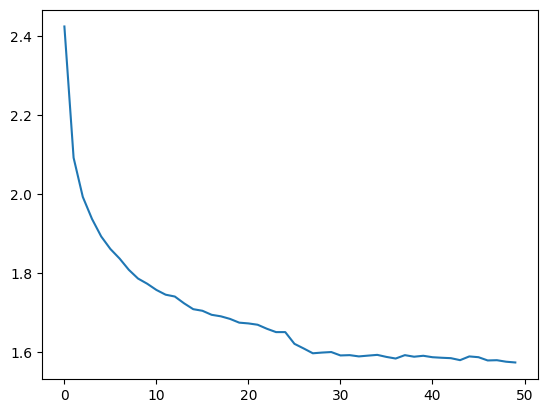

In [280]:
plt.plot(torch.tensor(losses).view(-1, 1000).mean(1))

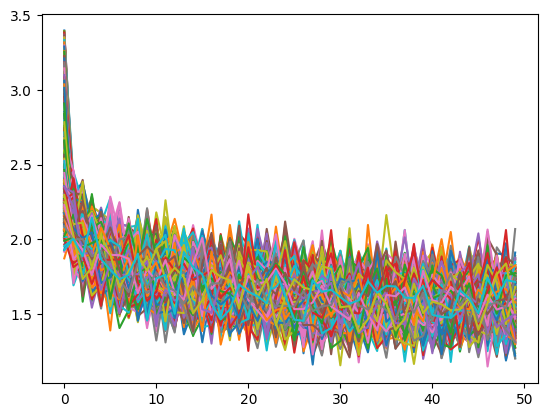

In [281]:
plt.plot(torch.tensor(losses).view(-1, 1000))

In [282]:
def complete_word(model, start_chars, block_size=8):
    context = [3] * (block_size - len(start_chars))
    context.extend([stoi[ch] for ch in start_chars])
    
    res = list(start_chars)
    
    while True:
        out = model.predict(torch.tensor([context]))
        
        out = F.softmax(out, dim=-1)
        out = torch.multinomial(out, 1).item()
        
        if out == 3:
            break
            
        res.append(itos[out])
        context = context[1:] + [out]
    
    return ''.join(res)

prompts = [
    "dream",
    "star",
    "moon",
    "whisper",
    "ember",
    "mist",
    "azure",
    "shadow",
    "crystal",
    "velvet",
    "river",
    "sunset",
    "autumn",
    "silver",
    "echo"
]

for word in prompts:
    res = complete_word(model, start_chars=word)
    # make sure there is only one space between words
    res = ' '.join([i.strip() for i in res.split()])
    print(res)

dream how be and see no resent here you's so dard now roblema
staring alward the insmone in the dons traft me
moonterlier now old engue i vent's snake by the gong al and the searts it need
whisper traction for the help
ember sayed to her
mist's chary what langly on evantelcomforts want sones of tea chined by thouggle and with day so depting with down
azure forcollet has deave in tunned g as stears i this suckic is of the pulling shake in sight as calm on learness our little did on my great my quicks and ennoter in the say sestion stainstendincing eachnay hell every roarriend fix slowd branckading through to be exhere is mornings well she this to the beauty shliegs so free on you delm new them us cushed
shadows smilious i lane promil
crystalling foom and your mertanons and thought fill of deather mool watch
velveting and oweremiling moonlerest drage swill your pectate intaking for that dreams
river no no haunt her time no is grey unned in my chals hurt
sunseto arail out and through the 